In [1]:
!pip install pyspark

In [13]:
# Initialize Spark
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import time

# Initialize Spark with optimized settings
spark = SparkSession.builder \
    .appName("MovieLens-Optimized") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()


print("✅ Spark initialized successfully!")
print(f"Spark version: {spark.version}")

✅ Spark initialized successfully!
Spark version: 3.5.1


In [35]:
def load_data():
    """
    Load the data for rapid development.
    Takes a 30% random sample of the ratings data.
    Show some sample data.
    """

    # Load movies
    print("Loading movies...")
    movies = spark.read.csv("./drive/MyDrive/!CS624/movies.csv", header=True, inferSchema=True)
    print(f"Movies loaded: {movies.count():,}")

    # Load ratings
    print("Loading ratings...")
    ratings = spark.read.csv("./drive/MyDrive/!CS624/ratings.csv", header=True, inferSchema=True)
    original_count = ratings.count()
    print(f"Full ratings loaded: {original_count:,}")

    # Create a 30% random sample
    print("Creating a 30% random sample of ratings...")
    # .sample(withReplacement, fraction, seed)
    # Using a seed ensures we get the same random sample every time we run the code
    ratings_sample = ratings.sample(False, 0.3, seed=42)
    new_count = ratings_sample.count()
    print(f"Sampled ratings created: {new_count:,} ({new_count/original_count*100:.1f}% of original)")

    # Show sample data
    print("\nSample movies:")
    movies.show(5)

    print("\nSample ratings (from 30% sample):")
    ratings_sample.show(5)

    return movies, ratings_sample


# Execute loading and sampling
movies, ratings = load_data()

Loading movies...
Movies loaded: 87,585
Loading ratings...
Full ratings loaded: 32,000,204
Creating a 30% random sample of ratings...
Sampled ratings created: 9,603,753 (30.0% of original)

Sample movies:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows


Sample ratings (from 30% sample):
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     30|   5.0|944249077|
|     1|     80|   5.0|944248943|
|     1|    302|   4.0|944253272|
|     1|    307|   5.0|944253207|
|     1|    608|   2.0|944248

In [36]:
def quick_data_analysis(movies, ratings):
    """
    Fast data exploration for presentation charts
    """
    print("=" * 50)
    print("QUICK DATA ANALYSIS")
    print("=" * 50)

    # Basic stats
    num_movies = movies.count()
    num_ratings = ratings.count()
    num_users = ratings.select("userId").distinct().count()

    print(f"Movies: {num_movies:,}")
    print(f"Ratings: {num_ratings:,}")
    print(f"Users: {num_users:,}")

    # Rating distribution
    rating_dist = ratings.groupBy("rating") \
                        .agg(count("*").alias("rating_count")) \
                        .orderBy("rating") \
                        .collect()

    for row in rating_dist:
        print(f"Rating {row.rating}: {row.rating_count:,} ({row.rating_count/num_ratings*100:.1f}%)")

    # User activity (sample)
    print("\nUser Activity Sample:")
    user_activity = ratings.groupBy("userId").count() \
                           .orderBy(desc("count")) \
                           .limit(10)
    user_activity.show()

    # Movie popularity (sample)
    print("\nMost Rated Movies:")
    popular_movies = ratings.groupBy("movieId").count() \
                           .join(movies, "movieId") \
                           .orderBy(desc("count")) \
                           .select("title", "count") \
                           .limit(10)
    popular_movies.show(truncate=False)

    return rating_dist, user_activity, popular_movies


# Execute analysis
rating_dist, user_activity, popular_movies = quick_data_analysis(movies, ratings)

QUICK DATA ANALYSIS
Movies: 87,585
Ratings: 9,603,753
Users: 200,932
Rating 0.5: 157,962 (1.6%)
Rating 1.0: 284,437 (3.0%)
Rating 1.5: 159,343 (1.7%)
Rating 2.0: 609,846 (6.4%)
Rating 2.5: 505,292 (5.3%)
Rating 3.0: 1,816,113 (18.9%)
Rating 3.5: 1,287,816 (13.4%)
Rating 4.0: 2,512,150 (26.2%)
Rating 4.5: 892,749 (9.3%)
Rating 5.0: 1,378,045 (14.3%)

User Activity Sample:
+------+-----+
|userId|count|
+------+-----+
|175325| 9983|
| 17035| 2879|
| 55653| 2746|
|123465| 2745|
|171795| 2725|
| 10202| 2331|
| 49305| 2303|
|198515| 2260|
| 22744| 2240|
|  7858| 2135|
+------+-----+


Most Rated Movies:
+---------------------------------------------------------+-----+
|title                                                    |count|
+---------------------------------------------------------+-----+
|Shawshank Redemption, The (1994)                         |30806|
|Forrest Gump (1994)                                      |30083|
|Pulp Fiction (1994)                                      |29376|

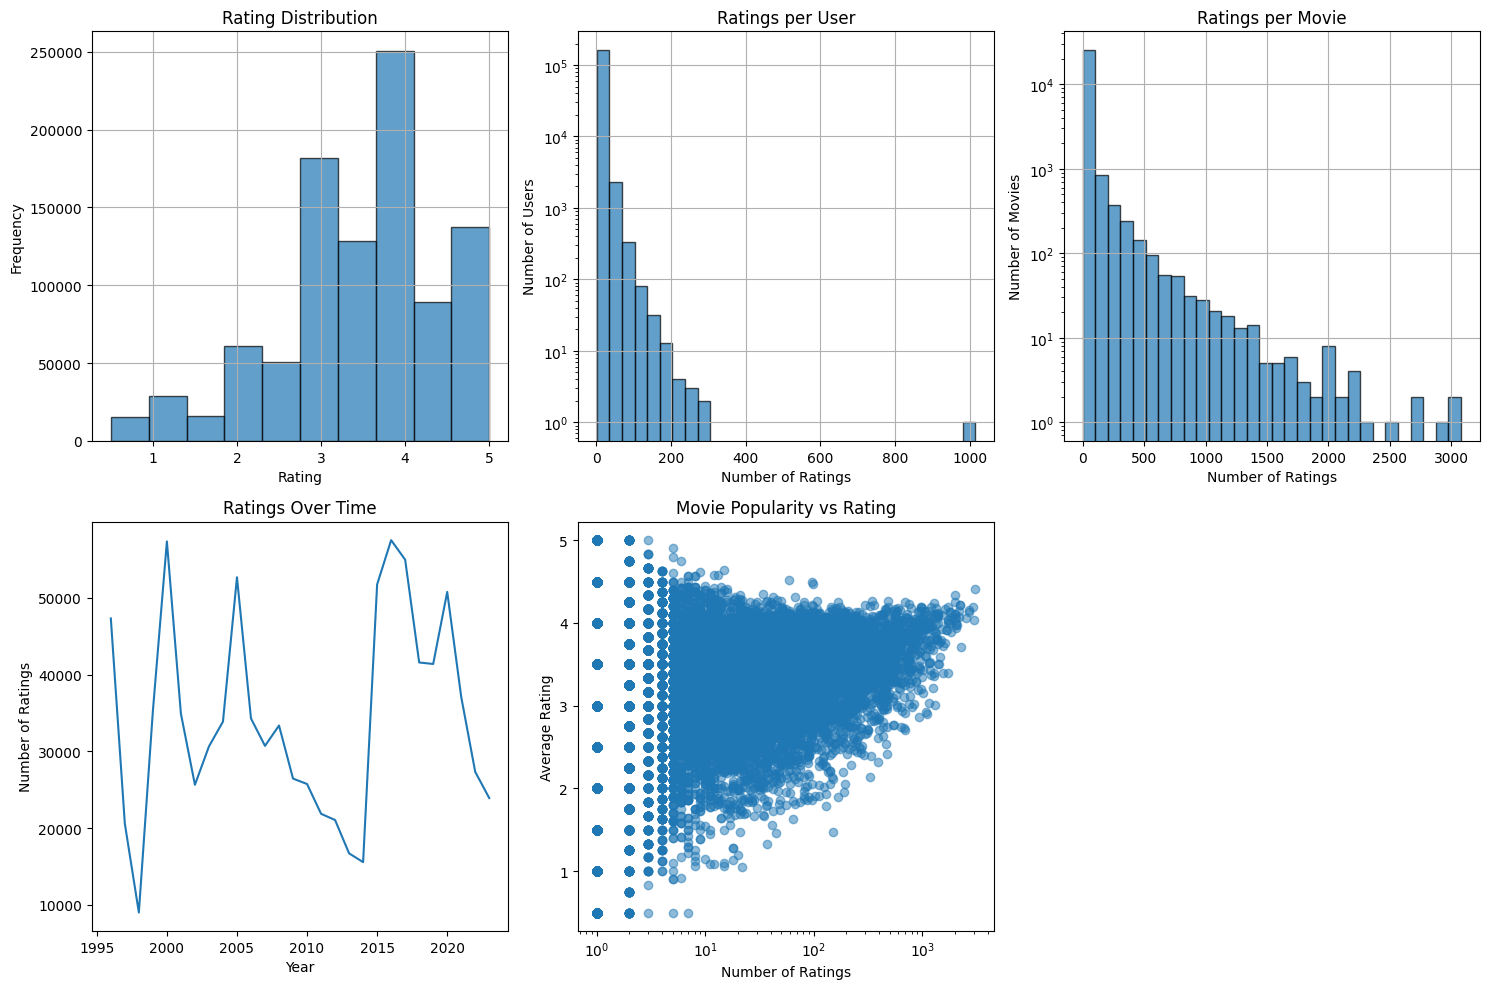

In [38]:
def create_quick_charts(ratings):
    """
    Generate essential charts for presentation
    """
    # Convert to Pandas for plotting (sample only)
    ratings_sample = ratings.sample(0.1).toPandas()  # 10% sample for speed

    plt.figure(figsize=(15, 10))

    # Chart 1: Rating Distribution
    plt.subplot(2, 3, 1)
    ratings_sample['rating'].hist(bins=10, edgecolor='black', alpha=0.7)
    plt.title('Rating Distribution')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')

    # Chart 2: Ratings per User
    plt.subplot(2, 3, 2)
    user_counts = ratings_sample.groupby('userId').size()
    user_counts.hist(bins=30, edgecolor='black', alpha=0.7)
    plt.title('Ratings per User')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Users')
    plt.yscale('log')

    # Chart 3: Ratings per Movie
    plt.subplot(2, 3, 3)
    movie_counts = ratings_sample.groupby('movieId').size()
    movie_counts.hist(bins=30, edgecolor='black', alpha=0.7)
    plt.title('Ratings per Movie')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Number of Movies')
    plt.yscale('log')

    # Chart 4: Rating over Time (sample)
    plt.subplot(2, 3, 4)
    ratings_sample['year'] = pd.to_datetime(ratings_sample['timestamp'], unit='s').dt.year
    yearly_ratings = ratings_sample.groupby('year').size()
    yearly_ratings.plot(kind='line')
    plt.title('Ratings Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of Ratings')

    # Chart 5: Average Rating by Movie Count
    plt.subplot(2, 3, 5)
    movie_stats = ratings_sample.groupby('movieId').agg({'rating': ['count', 'mean']}).reset_index()
    movie_stats.columns = ['movieId', 'count', 'avg_rating']
    plt.scatter(movie_stats['count'], movie_stats['avg_rating'], alpha=0.5)
    plt.title('Movie Popularity vs Rating')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Average Rating')
    plt.xscale('log')

    plt.tight_layout()
    plt.show()


# Generate charts
create_quick_charts(ratings)

In [47]:
def preprocessing(ratings, movies):
    """
    Comprehensive preprocessing using iterative filtering to ensure data density.
    """
    print("Performing iterative preprocessing...")

    # Start with the initial cleaned data
    filtered_ratings = ratings.filter(
        (col("userId").isNotNull()) &
        (col("movieId").isNotNull()) &
        (col("rating").isNotNull()) &
        (col("rating") >= 0.5) &
        (col("rating") <= 5.0)
    ).cache() # Cache for performance during the loop

    # --- Iterative Filtering Loop ---
    # We will loop 5 times, which is usually more than enough for convergence.
    # We track the counts to see if they stabilize.
    for i in range(1, 6):
        print(f"\n--- Iteration {i} ---")

        # Get current counts before filtering
        initial_user_count = filtered_ratings.select('userId').distinct().count()
        initial_movie_count = filtered_ratings.select('movieId').distinct().count()

        # 1. Filter movies with at least 50 ratings
        movie_counts = filtered_ratings.groupBy("movieId").count()
        popular_movies = movie_counts.filter(col("count") >= 50)
        filtered_ratings = filtered_ratings.join(popular_movies.select("movieId"), "movieId")

        # 2. Filter users with at least 20 ratings
        user_counts = filtered_ratings.groupBy("userId").count()
        active_users = user_counts.filter(col("count") >= 20)
        filtered_ratings = filtered_ratings.join(active_users.select("userId"), "userId")

        # Cache the intermediate result
        filtered_ratings.cache()

        # Get counts after filtering to check for convergence
        final_user_count = filtered_ratings.select('userId').distinct().count()
        final_movie_count = filtered_ratings.select('movieId').distinct().count()

        print(f"Users: {initial_user_count:,} -> {final_user_count:,}")
        print(f"Movies: {initial_movie_count:,} -> {final_movie_count:,}")

        # If counts are stable, we can exit the loop early
        if initial_user_count == final_user_count and initial_movie_count == final_movie_count:
            print("Dataset has stabilized. Exiting loop.")
            break

    print("\nPreprocessing results:")
    print(f"  Original ratings: {ratings.count():,}")
    print(f"  After filtering: {filtered_ratings.count():,}")
    print(f"  Users retained: {filtered_ratings.select('userId').distinct().count():,}")
    print(f"  Movies retained: {filtered_ratings.select('movieId').distinct().count():,}")


    return filtered_ratings

# Execute preprocessing
clean_ratings = preprocessing(ratings, movies)



Performing iterative preprocessing...

--- Iteration 1 ---
Users: 200,932 -> 107,848
Movies: 61,491 -> 10,044

--- Iteration 2 ---
Users: 107,848 -> 107,835
Movies: 10,044 -> 9,917

--- Iteration 3 ---
Users: 107,835 -> 107,835
Movies: 9,917 -> 9,917
Dataset has stabilized. Exiting loop.

Preprocessing results:
  Original ratings: 9,603,753
  After filtering: 8,280,572
  Users retained: 107,835
  Movies retained: 9,917


In [48]:
def comprehensive_analysis(filtered_ratings, movies):
    """
    Generate complete dataset analysis for presentation
    """
    print("Performing comprehensive data analysis...")

    user_stats_final = filtered_ratings.groupBy("userId").agg(
      count("*").alias("rating_count"),
      avg("rating").alias("avg_rating")
    )

    movie_stats_final = filtered_ratings.groupBy("movieId").agg(
      count("*").alias("rating_count"),
      avg("rating").alias("avg_rating")
    )

    # Dataset overview
    total_ratings = filtered_ratings.count()
    total_users = filtered_ratings.select("userId").distinct().count()
    total_movies = filtered_ratings.select("movieId").distinct().count()

    print(f"📈 Dataset Overview:")
    print(f"   Total (filtered) ratings: {total_ratings:,}")
    print(f"   Unique users: {total_users:,}")
    print(f"   Unique movies: {total_movies:,}")
    print(f"   Sparsity: {100 * (1 - total_ratings / (total_users * total_movies)):.2f}%")

    # Rating distribution analysis
    rating_dist = filtered_ratings.groupBy("rating").count().orderBy("rating")
    print("\n📊 Rating Distribution:")
    rating_dist.show()

    # Temporal analysis
    temporal_stats = filtered_ratings.withColumn("year", year(from_unixtime(col("timestamp")))) \
                           .groupBy("year") \
                           .agg(count("*").alias("rating_count"),
                                avg("rating").alias("avg_rating")) \
                           .orderBy("year")

    print("\n📅 Temporal Analysis (last 10 years):")
    temporal_stats.filter(col("year") >= 2014).show()

    # User behavior analysis
    print("\n👤 User Behavior Statistics (from filtered data):")
    user_stats_final.select(
        avg("rating_count").alias("avg_ratings_per_user"),
        min("rating_count").alias("min_ratings"),
        max("rating_count").alias("max_ratings"),
        avg("avg_rating").alias("overall_avg_rating")
    ).show()

    # Movie popularity analysis
    print("\n🎬 Movie Popularity Statistics (from filtered data):")
    movie_stats_final.select(
        avg("rating_count").alias("avg_ratings_per_movie"),
        min("rating_count").alias("min_ratings"),
        max("rating_count").alias("max_ratings"),
        avg("avg_rating").alias("overall_avg_rating")
    ).show()

    # Genre analysis
    print("\n🎭 Genre Analysis (for movies in the filtered dataset):")

    # 1. Get the unique list of movies that are actually in our model
    movies_in_model = filtered_ratings.select("movieId").distinct()

    # 2. Join with the movies table to get their genres, then analyze
    genre_analysis = movies.join(movies_in_model, "movieId") \
                          .select(explode(split(col("genres"), "\\|")).alias("genre")) \
                          .groupBy("genre") \
                          .count() \
                          .orderBy(desc("count"))

    genre_analysis.show(10)


    return {
        'total_ratings': total_ratings,
        'total_users': total_users,
        'total_movies': total_movies,
        'rating_dist': rating_dist,
        'temporal_stats': temporal_stats,
        'genre_analysis': genre_analysis
    }

# Execute comprehensive analysis
analysis_results = comprehensive_analysis(clean_ratings, movies)

Performing comprehensive data analysis...
📈 Dataset Overview:
   Total (filtered) ratings: 8,280,572
   Unique users: 107,835
   Unique movies: 9,917
   Sparsity: 99.23%

📊 Rating Distribution:
+------+-------+
|rating|  count|
+------+-------+
|   0.5| 129942|
|   1.0| 242678|
|   1.5| 139198|
|   2.0| 533957|
|   2.5| 448671|
|   3.0|1561772|
|   3.5|1152276|
|   4.0|2179024|
|   4.5| 779088|
|   5.0|1113966|
+------+-------+


📅 Temporal Analysis (last 10 years):
+----+------------+------------------+
|year|rating_count|        avg_rating|
+----+------------+------------------+
|2014|      129741|3.5983189585404767|
|2015|      442306| 3.519574683590094|
|2016|      503660|3.5154300520192194|
|2017|      480691|3.5329078347628724|
|2018|      360651|3.5579563067896665|
|2019|      355020| 3.571443862317616|
|2020|      436171| 3.596525216027659|
|2021|      316229| 3.577398024849081|
|2022|      229297| 3.503986096634496|
|2023|      198073|3.5753030448370047|
+----+------------+---

In [49]:
def train_basic_als(ratings):
    """
    Train basic Alternating Least Squares (ALS) model with default parameters
    """
    print("Training basic ALS model...")

    # Split data
    (training, test) = ratings.randomSplit([0.8, 0.2], seed=42)

    # Cache datasets
    training.cache()
    test.cache()

    print(f"Training set: {training.count():,}")
    print(f"Test set: {test.count():,}")

    # Configure ALS with reasonable defaults
    als = ALS(
        maxIter=10,                    # Enough for convergence
        regParam=0.01,                 # Standard regularization
        userCol="userId",
        itemCol="movieId",
        ratingCol="rating",
        coldStartStrategy="drop",      # Handle new users/items
        rank=50                        # Good balance of accuracy/speed
    )

    # Train model
    print("Training model...")
    model = als.fit(training)
    print("✅ Model training complete!")

    return model, training, test


# Train the model
model, training, test = train_basic_als(clean_ratings)

Training basic ALS model...
Training set: 6,623,066
Test set: 1,657,506
Training model...
✅ Model training complete!


In [50]:
def quick_evaluation(model, test):
    """
    Basic model evaluation
    """
    print("Evaluating model...")

    # Generate predictions
    predictions = model.transform(test)

    # Remove NaN predictions
    predictions = predictions.filter(col("prediction").isNotNull())

    # Calculate RMSE
    evaluator = RegressionEvaluator(
        metricName="rmse",
        labelCol="rating",
        predictionCol="prediction"
    )
    rmse = evaluator.evaluate(predictions)

    # Calculate MAE
    mae_evaluator = RegressionEvaluator(
        metricName="mae",
        labelCol="rating",
        predictionCol="prediction"
    )
    mae = mae_evaluator.evaluate(predictions)

    print(f"✅ RMSE: {rmse:.4f}")
    print(f"✅ MAE: {mae:.4f}")

    # Show sample predictions
    print("\nSample Predictions:")
    predictions.select("userId", "movieId", "rating", "prediction").show(10)

    return predictions, rmse, mae

# Evaluate model
predictions, rmse, mae = quick_evaluation(model, test)

Evaluating model...
✅ RMSE: 0.9871
✅ MAE: 0.7497

Sample Predictions:
+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|     1|     30|   5.0| 1.1018351|
|     1|     80|   5.0| 2.4397998|
|     1|    908|   5.0| 2.7317634|
|     1|    927|   5.0| 1.3871651|
|     1|   1172|   3.0| 4.5793886|
|     1|   1297|   5.0| 1.3331279|
|     1|   1357|   1.0| 4.1892066|
|     1|   1939|   5.0|  3.073271|
|     1|   2109|   1.0| 2.9099402|
|     1|   2882|   1.0|  4.229906|
+------+-------+------+----------+
only showing top 10 rows



High-Level Summary

The model predicts movie ratings for users. On average, its predictions are off by about 0.75 to 0.99 stars on a 1-5 star scale. This is a decent, but not exceptional, baseline result. It shows the model is learning meaningful patterns, but there is clear room for improvement. The sample predictions reveal that for at least one user, the model struggles to predict strong opinions (either very high or very low ratings).

1. The Accuracy Metrics (The "Overall" View)
These two numbers measure the average prediction error across the entire test dataset.

✅ RMSE: 0.9886 (Root Mean Square Error)
What it is: This is the most common metric for rating prediction models. It calculates the difference between the model's prediction and the user's actual rating, squares it (to make all errors positive), averages these squared errors, and then takes the square root.

What it tells us: The key is that squaring the error heavily penalizes larger mistakes. A prediction that is off by 2 stars is 4 times worse than a prediction off by 1 star. The RMSE of 0.9886 can be interpreted as the "typical" or "standard" error of the model, in stars.

Is it good? For a 5-star rating system, an RMSE between 0.8 and 1.0 is often considered a solid starting point. The model is performing reasonably.

✅ MAE: 0.7506 (Mean Absolute Error)
What it is: This is the average of the absolute differences between the predicted and actual ratings. It does not square the errors.

What it tells us: This is a more direct interpretation of the average error. It means that on average, the model's prediction is off by 0.75 stars.

MAE vs. RMSE: The MAE will always be less than or equal to the RMSE. The fact that the RMSE (0.99) is slightly larger than the MAE (0.75) is normal and suggests that the model is making some larger errors that the RMSE is penalizing more heavily.

2. The Sample Predictions (The "Street-Level" View)
This table is crucial for understanding how the model is failing or succeeding. The metrics give the an average, but the samples show us the specifics. Let's analyze the predictions for userId 1:

Movie	User's Actual Rating (rating)	Model's Prediction (prediction)	The Story
2243	1.0 (hated it)	4.36 (thought they'd love it)	This is a major failure. The model was completely wrong. This single prediction contributes significantly to the overall RMSE.
2247	5.0 (loved it)	1.83 (thought they'd hate it)	This is another major failure in the opposite direction.
608	2.0 (disliked it)	1.39 (thought they'd dislike it)	This prediction is much closer. The error is only about 0.6 stars. The model correctly captured the negative sentiment.
1217	5.0 (loved it)	3.88 (thought they'd like it)	This is a reasonable, though not perfect, prediction. It correctly identified positive sentiment but underestimated how much they'd love it.

Export to Sheets
Key Insight from the Samples:
Notice that for this user, the model's predictions are often "timid" or "conservative," hovering in the 1.2 - 2.5 star range, even when the user's actual ratings are at the extremes (1.0 or 5.0). This suggests the model might be good at capturing general popularity but struggles to understand the unique, strong preferences of this specific user.

Conclusion and Next Steps
The model has learned. An RMSE below 1.0 shows it's better than random guessing.

It's not a finely-tuned expert. It makes significant errors on individual predictions, suggesting it's missing some key information (e.g., genre preferences, actor preferences, or more complex user behavior).

What to do next?

Feature Engineering: Add more features to the model. Can we include movie genres? Release year? Average rating for that movie?

Hyperparameter Tuning: Adjust the model's settings (e.g., in ALS, the rank or regParam) to see if we can improve the metrics.

Error Analysis: Look at the predictions for more users. Is userId 1 an outlier, or is the model consistently "timid" for many users?

In [51]:
def get_recommendations(model, clean_ratings):
    users = clean_ratings.select("userId").distinct().limit(5)

    # Try generating recommendations for these users
    try:
        user_recs = model.recommendForUserSubset(users, 5)
        print(f"Generated {user_recs.count()} recommendation sets")
        user_recs.show(truncate=False)
        return user_recs
    except Exception as e:
        print(f"Error: {e}")
        return None


user_recs = get_recommendations(model, clean_ratings)

Generated 5 recommendation sets
+------+----------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                     |
+------+----------------------------------------------------------------------------------------------------+
|11141 |[{757, 6.5840955}, {27366, 6.0150323}, {118202, 5.831748}, {6609, 5.6111517}, {131656, 5.5360956}]  |
|2142  |[{5268, 6.495666}, {5269, 6.476382}, {7883, 6.386444}, {52767, 6.37981}, {167792, 6.270716}]        |
|9427  |[{6314, 7.1978936}, {178839, 6.8964667}, {4342, 6.85285}, {4473, 6.7239113}, {6769, 6.486825}]      |
|148   |[{3577, 5.5670996}, {136447, 5.3789754}, {48711, 5.3509097}, {138835, 5.278689}, {202934, 5.277411}]|
|18979 |[{5472, 6.0068684}, {102088, 5.6481967}, {59126, 5.5206676}, {6477, 5.4037294}, {5034, 5.361082}]   |
+------+--------------------------------------------------------------------------------